# Fast-GNN, Neighbor Sampling, Minibatch

In [1]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

NUM_PROCESSORS

32

In [2]:
import multiprocessing

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

Cpu count:  32


In [3]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, PPI, Planetoid
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from torch_geometric.loader import NeighborSampler, NeighborLoader
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time


## Define the dataset, the type of prediction and the number of samples

In [4]:
DATASET = 'cora'
PREDICTION = 'link'
RUN_COUNT = 1
NUM_SAMPLES = 1
PATH_TO_DATASETS_DIRECTORY = DIR

In [5]:
datasets = {
    #'reddit': Reddit(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Reddit'),
    'cora' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Cora/', name='Cora'),
    #'citeseer' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/CiteSeer/', name='CiteSeer'),
    #'pubmed' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/PubMed/', name='PubMed'),
}
dataset = datasets[DATASET]
data = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [6]:
print("Printing Dataset Characteristics")
print("Name: ", DATASET)
print("Total Number of Nodes: ", data.num_nodes)
print("Total Number of Training Nodes: ", data.train_mask.sum().item())
print("Total Number of Val Nodes: ", data.val_mask.sum().item())
print("Total Number of Test Nodes: ", data.test_mask.sum().item())
print("Num Node Features: ", data.num_features)
print("Num Node Classes: ", dataset.num_classes)
print("Number of Edges: ", data.edge_index.shape[1])
print("Number of Samples for structural: ", NUM_SAMPLES)
print("Prediction Type: ", PREDICTION)

Printing Dataset Characteristics
Name:  cora
Total Number of Nodes:  2708
Total Number of Training Nodes:  140
Total Number of Val Nodes:  500
Total Number of Test Nodes:  1000
Num Node Features:  1433
Num Node Classes:  7
Number of Edges:  10556
Number of Samples for structural:  1
Prediction Type:  link


In [7]:
#data.train_mask = 1 - data.val_mask - data.test_mask
data.train_mask = ~(data.val_mask + data.test_mask)

adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
edges = data.edge_index.t()
adj_mat[edges[:,0], edges[:,1]] = 1

## Build the non-overlapping induced subgraphs

In [8]:
adj_train = adj_mat[data.train_mask].t()[data.train_mask].t()
adj_validation = adj_mat[data.val_mask].t()[data.val_mask].t()
adj_test = adj_mat[data.test_mask].t()[data.test_mask].t()

## Corrupt a small fraction of the edges

In [9]:
def corrupt_adj(adj_mat, task, percent=2):
    """ Returns the corrupted version of the adjacency matrix """
    if task == 'link':
        edges = adj_mat.triu().nonzero()
        num_edges = edges.shape[0]
        num_to_corrupt = int(percent/100.0 * num_edges)
        random_corruption = np.random.randint(num_edges, size=num_to_corrupt)
        adj_mat_corrupted = adj_mat.clone()
        false_edges, false_non_edges = [], []
        #Edge Corruption
        for ed in edges[random_corruption]:
            adj_mat_corrupted[ed[0], ed[1]] = 0
            adj_mat_corrupted[ed[1], ed[0]] = 0
            false_non_edges.append(ed.tolist())
        #Non Edge Corruption
        random_non_edge_corruption = list(np.random.randint(adj_mat.shape[0], size = 6*num_to_corrupt))
        non_edge_to_corrupt = []
        for k in range(len(random_non_edge_corruption)-1):
            to_check = [random_non_edge_corruption[k], random_non_edge_corruption[k+1]]
            if to_check not in edges.tolist():
                non_edge_to_corrupt.append(to_check)
            if len(non_edge_to_corrupt) == num_to_corrupt:
                break
        non_edge_to_corrupt = torch.Tensor(non_edge_to_corrupt).type(torch.int16)
        for n_ed in non_edge_to_corrupt:
            adj_mat_corrupted[n_ed[0], n_ed[1]] = 1
            adj_mat_corrupted[n_ed[1], n_ed[0]] = 1
            false_edges.append(n_ed.tolist())
    return adj_mat_corrupted, false_edges, false_non_edges


In [10]:
adj_train_corrupted, train_false_edges, train_false_non_edges = corrupt_adj(adj_train, 'link', percent=2)
adj_val_corrupted, val_false_edges, val_false_non_edges = corrupt_adj(adj_validation, 'link', percent=2)
adj_test_corrupted, test_false_edges, test_false_non_edges  = corrupt_adj(adj_test, 'link', percent=2)

G_train=Data(edge_index=(adj_train_corrupted.nonzero()).t(), x=data.x[data.train_mask])
G_val=Data(edge_index=(adj_val_corrupted.nonzero()).t(), x=data.x[data.val_mask])
G_test=Data(edge_index=(adj_test_corrupted.nonzero()).t(), x=data.x[data.test_mask])

## Define the GNN network

In [55]:
num_neurons = 256
input_rep = data.num_features

from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
GNNlayer=GCNConv

class JointGNN(nn.Module):
    def __init__(self):
        super(JointGNN, self).__init__()
        
        ##GNN layer
        if(GNNlayer==GINConv):
            self.MLP1 = nn.Linear(input_rep,num_neurons)
            self.MLP2 = nn.Linear(num_neurons,num_neurons)
            self.GNN_layer1 = GNNlayer(self.MLP1)
            self.GNN_layer2 = GNNlayer(self.MLP2)        
        else:
            self.GNN_layer1 = GNNlayer(input_rep,num_neurons)
            self.GNN_layer2 = GNNlayer(num_neurons,num_neurons) 
            
            
        ##Deepset MLP
        self.ds_layer_1 = nn.Linear(num_neurons, num_neurons)
        self.rho_layer_1 = nn.Linear(num_neurons, num_neurons)
        
        ##Prediction Layer        
        self.linear1 = nn.Linear(num_neurons,num_neurons)
        self.linear2 = nn.Linear(num_neurons,2)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, subgraphs, nodes, edges):
        
        
        node_tensor = torch.zeros((len(nodes), num_neurons)).to(device)
        node_count = torch.zeros((len(nodes)),requires_grad=False).to(device)
        
        graph=subgraphs[0]        
        x=graph.x_feature
        
        x=self.GNN_layer1(x,graph.edge_index)
        x=self.relu(x)

        x=self.GNN_layer2(x,graph.edge_index)
        x=self.relu(x)
                                
#                 #deepsets
#                 y=self.ds_layer_1(y)
#                 y=self.relu(y)                
#                 y=self.rho_layer_1(y)
#                 y=self.relu(y)
            
        ##filter only edges
        x = x[:2*edges.shape[0],:]
        
        #print("x: ", x.shape, "edges: ",edges.shape)
        
        x_halved = x[::2] + x[1::2]
        
        #print("x half: ",x_halved.shape)
        
        #One Hidden Layer for predictor        
        z_tensor = self.linear1(x_halved)
        z_tensor = self.relu(z_tensor)
        z_tensor = self.linear2(z_tensor)
        
        return z_tensor

    def compute_loss(self, subgraphs, nodes, edges, target):
        
        pred = self.forward(subgraphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)                
        
        return loss
    
    def predict(self, subgraphs, nodes, edges, target):
        
        pred = self.forward(subgraphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)
        
        return loss, pred
        
        

## Sample positive and negative edges

In [56]:
def sample_equal_number_edges_non_edges(adj_mat, false_non_edges, false_edges, small_samples):
    edges = adj_mat.nonzero()
    num_edges = edges.shape[0]
    inverse_adj_mat = 1 - adj_mat
    non_edges = inverse_adj_mat.nonzero()
    num_non_edges  = non_edges.shape[0]
    
    edges_sampled = edges[np.random.randint(num_edges, size=small_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=small_samples)]
    final_edges = []
    final_non_edges = []
    for ed in edges_sampled.tolist():
        if ed not in false_edges:
            final_edges.append(ed)
    final_edges += false_non_edges
    for n_ed in non_edges_sampled.tolist():
        if n_ed not in false_non_edges:
            final_non_edges.append(n_ed)
    final_non_edges += false_edges

    return final_edges, final_non_edges

from sklearn.neighbors import kneighbors_graph

def sample_train_edges_nearest_neighbor(train_feature, adj_mat, false_non_edges, false_edges, small_samples):
    edges = adj_mat.nonzero()
    num_edges = edges.shape[0]
    
    k=5
    A = kneighbors_graph(train_feature, k, mode="connectivity", metric="cosine", include_self=False)        
    (u,v)=A.nonzero()
    u=torch.Tensor(u).type(torch.long)
    v=torch.Tensor(v).type(torch.long)
    possible_edges=torch.stack((u,v),dim=1)
    possible_adj_mat = torch.zeros((adj_mat.shape))
    possible_adj_mat[possible_edges[:,0], possible_edges[:,1]] = 1
    
    inverse_adj_mat=possible_adj_mat-adj_mat
    inverse_adj_mat[inverse_adj_mat==-1]=0
    non_edges = inverse_adj_mat.nonzero()  
    
    print(non_edges.shape)
    
    num_non_edges  = non_edges.shape[0]
    edges_sampled = edges[np.random.randint(num_edges, size=small_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=small_samples)]
    final_edges = []
    final_non_edges = []
    for ed in edges_sampled.tolist():
        if ed not in false_edges:
            final_edges.append(ed)
    final_edges += false_non_edges
    for n_ed in non_edges_sampled.tolist():
        if n_ed not in false_non_edges:
            final_non_edges.append(n_ed)
    final_non_edges += false_edges

    return final_edges, final_non_edges

# edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
# edges, non_edges = sample_train_edges_nearest_neighbor(G_train.x, adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)


## Minibatch of edges

In [57]:
class MiniBatcher(object):
    def __init__(self, batch_size, n_examples, shuffle=True):
        assert batch_size <= n_examples, "Error: batch_size is larger than n_examples"
        self.batch_size = batch_size
        self.n_examples = n_examples
        self.shuffle = shuffle
        logging.info("batch_size={}, n_examples={}".format(batch_size, n_examples))

        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0

    def get_one_batch(self):
        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0
        while self.current_start < self.n_examples:
            batch_idxs = self.idxs[self.current_start:self.current_start+self.batch_size]
            self.current_start += self.batch_size
            yield torch.LongTensor(batch_idxs)

## Prediction

In [58]:
def generateSubgraphs(G_graph, x_edges, neighbor_sampler):
    nodes=torch.flatten(torch.cat((x_edges,x_edges),dim=0))
    
    #print(nodes)
    
    node, row, col, edge, numbers = neighbor_sampler.neighbor_sampler(nodes.cpu())
    
    #print(node)
    
    subgraphs=[]
    
    graph = Data()
    
    graph.x_feature = G_graph.x[node]  
        
    graph.edge_index = torch.stack((row,col),dim=0)
    
    #print(graph)

    subgraphs.append(graph.to(device))
        
    return subgraphs

def predict_model(model,G_data, neighbor_sampler, minibatch_size, small_samples, adj_corrupted, false_non_edges, false_edges):
    model.eval()
    preds=np.array([])
    targets=np.array([])
    total_loss=0
    
    edges, non_edges = sample_equal_number_edges_non_edges(adj_corrupted, false_non_edges, false_edges, small_samples)    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    true_target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
    
    batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
    t_start = time.time()
    
    with torch.no_grad():
        for x_idxs in batcher.get_one_batch():
            x_idxs = x_idxs.to(device)

            x_edges=samples[x_idxs]
            y_target=true_target[x_idxs]
            
            nodes=torch.unique(torch.flatten(x_edges).view(-1))

            subgraphs=generateSubgraphs(G_data, x_edges, neighbor_sampler)

            loss, pred=model.predict(subgraphs, nodes, x_edges, y_target)                          
            total_loss+=loss.item()
            
            pred = F.log_softmax(pred, dim=1)
            pred = pred.detach().to("cpu").numpy()
            pred = np.argmax(pred, axis=1)
                          
            preds = np.append(preds,pred)
            targets = np.append(targets,y_target.detach().to("cpu").numpy())
        

    micro=f1_score(targets, preds, average='micro')
    weighted=f1_score(targets, preds, average='weighted')
    acc=accuracy_score(targets, preds)
    
    return total_loss, acc, micro, weighted


# gnn_model = JointGNN().to(device)
# small_samples = 200
# minibatch_size=1
# neighbor_minibatch_size= 2 #for current implementation use 2 for now
# train_neighbor_sampler=NeighborLoader(G_train,num_neighbors=[2],batch_size=neighbor_minibatch_size)
# edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
# samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
# true_target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
# batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
# x_idxs = next(batcher.get_one_batch())
# x_idxs = x_idxs.to(device)

# # print(x_idxs)

# x_edges=samples[x_idxs]
# y_target=true_target[x_idxs]

# # print(x_edges)

# nodes=torch.unique(torch.flatten(x_edges).view(-1))
# print(nodes)
# subgraphs = generateSubgraphs(G_train, x_edges, train_neighbor_sampler)
# gnn_model.predict(subgraphs, nodes, x_edges, y_target)                         

## Plot Accuracy and Loss 

In [59]:
def save_plot(train_data, valid_data, name='Loss'):
    """Plot
        Plot one figure: accurace/loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_data)
    xs = np.arange(n)

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_data, '--', linewidth=2, label='train')
    ax.plot(xs, valid_data, '-', linewidth=2, label='valid')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(name)
    ax.legend(loc='lower right')
    plt.show()
    plt.savefig('train_valid_'+name+'.png')

In [62]:
from ipynb.fs.full.AGSNodeSampler import WeightedNeighborLoader

## Train the model

Minibatch time:  0.08477354049682617
Saving model Validation accuracy:  0.5037037037037037
----------------------------------------------------------------------------------------------------
[Epoch 0] Train Loss: 19.343814373016357, Train Accuracy: 0.5213483146067416, Val Loss 18.040561735630035, Val Accuracy: 0.5037037037037037
Minibatch time:  0.0911095142364502
Saving model Validation accuracy:  0.6379310344827587
----------------------------------------------------------------------------------------------------
[Epoch 1] Train Loss: 18.860410809516907, Train Accuracy: 0.5640449438202247, Val Loss 17.306827306747437, Val Accuracy: 0.6379310344827587
Minibatch time:  0.0899207592010498
----------------------------------------------------------------------------------------------------
[Epoch 2] Train Loss: 17.678629964590073, Train Accuracy: 0.6606741573033708, Val Loss 17.26197040081024, Val Accuracy: 0.6123456790123457
Minibatch time:  0.09079647064208984
------------------------

Minibatch time:  0.09090280532836914
----------------------------------------------------------------------------------------------------
[Epoch 29] Train Loss: 12.24601449072361, Train Accuracy: 0.8139013452914798, Val Loss 16.66767430305481, Val Accuracy: 0.6237623762376238
Minibatch time:  0.09097552299499512
----------------------------------------------------------------------------------------------------
[Epoch 30] Train Loss: 10.742432191967964, Train Accuracy: 0.827354260089686, Val Loss 15.00509798526764, Val Accuracy: 0.7346437346437347
Minibatch time:  0.08921027183532715
----------------------------------------------------------------------------------------------------
[Epoch 31] Train Loss: 11.22580374777317, Train Accuracy: 0.8280542986425339, Val Loss 16.512941598892212, Val Accuracy: 0.5759803921568627
Minibatch time:  0.09175443649291992
----------------------------------------------------------------------------------------------------
[Epoch 32] Train Loss: 10.7987

Minibatch time:  0.09002065658569336
----------------------------------------------------------------------------------------------------
[Epoch 58] Train Loss: 8.824926808476448, Train Accuracy: 0.8719101123595505, Val Loss 14.851517051458359, Val Accuracy: 0.7209876543209877
Minibatch time:  0.09121823310852051
Saving model Validation accuracy:  0.7857142857142857
----------------------------------------------------------------------------------------------------
[Epoch 59] Train Loss: 8.637315891683102, Train Accuracy: 0.8896396396396397, Val Loss 13.058896839618683, Val Accuracy: 0.7857142857142857
Minibatch time:  0.09067869186401367
----------------------------------------------------------------------------------------------------
[Epoch 60] Train Loss: 8.551770478487015, Train Accuracy: 0.8707482993197279, Val Loss 13.446531265974045, Val Accuracy: 0.7518427518427518
Minibatch time:  0.09177374839782715
Saving model Validation accuracy:  0.7960687960687961
---------------------

Minibatch time:  0.08978962898254395
----------------------------------------------------------------------------------------------------
[Epoch 88] Train Loss: 6.636971563100815, Train Accuracy: 0.9213483146067416, Val Loss 12.796343103051186, Val Accuracy: 0.7703703703703704
Minibatch time:  0.08357763290405273
----------------------------------------------------------------------------------------------------
[Epoch 89] Train Loss: 7.372592216357589, Train Accuracy: 0.903370786516854, Val Loss 14.719828844070435, Val Accuracy: 0.7272727272727273
Minibatch time:  0.09486055374145508
----------------------------------------------------------------------------------------------------
[Epoch 90] Train Loss: 7.583129737526178, Train Accuracy: 0.8921348314606742, Val Loss 15.33514016866684, Val Accuracy: 0.7339901477832512
Minibatch time:  0.09251642227172852
----------------------------------------------------------------------------------------------------
[Epoch 91] Train Loss: 6.50590

<Figure size 432x288 with 0 Axes>

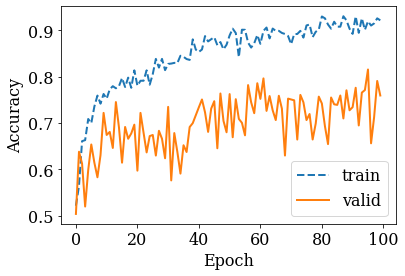

<Figure size 432x288 with 0 Axes>

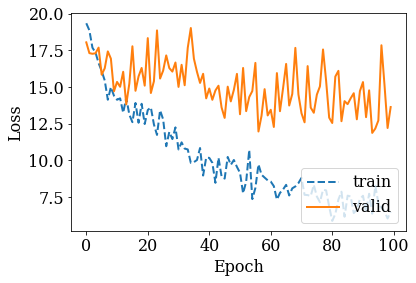

Best validation accuracy:  0.8152709359605911


<Figure size 432x288 with 0 Axes>

In [65]:
gnn_model = JointGNN().to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
gnn_best_model = DIR+'2best_gnn_inductive_model.model'
gnn_last_model = DIR+'2last_gnn_inductive_model.model'

epochs = 100
validation_acc = 0
small_samples = 200

minibatch_size=16
neighbor_minibatch_size=2 #for current implementation use 2 for now

RANDOM= True

if RANDOM:
    train_neighbor_sampler=NeighborLoader(G_train,num_neighbors=[8, 4],batch_size=neighbor_minibatch_size)
    val_neighbor_sampler=NeighborLoader(G_val,num_neighbors=[8, 4],batch_size=neighbor_minibatch_size)
    test_neighbor_sampler=NeighborLoader(G_test,num_neighbors=[8, 4],batch_size=neighbor_minibatch_size)

else:
    weight_func=['knn']; 
    params={
        'knn':{'metric':'cosine'},
        'submodular':{'metric':'cosine'},
        'link-nn':{'value':'min'},
        'link-sub':{'value':'max'},
        'apricot':{'sub_func':'coverage','metric':'cosine'}
    }    
    
    sampler_dir = DIR+'AGSGNNstrucCorrect/'+DATASET+PREDICTION
    print(sampler_dir)
    
    
    train_neighbor_sampler = WeightedNeighborLoader(
        G_train,num_neighbors=[8, 4], batch_size=neighbor_minibatch_size, 
        weight_func=weight_func, params=params, log=True, directed=True, replace = False,
        save_dir = sampler_dir+'train',recompute = True)

    val_neighbor_sampler = WeightedNeighborLoader(
        G_val,num_neighbors=[8, 4], batch_size=neighbor_minibatch_size, 
        weight_func=weight_func, params=params, log=True, directed=True, replace = False,
        save_dir = sampler_dir+'val',recompute = True)

    test_neighbor_sampler = WeightedNeighborLoader(
        G_test,num_neighbors=[8, 4], batch_size=neighbor_minibatch_size, 
        weight_func=weight_func, params=params, log=True, directed=True, replace = False,
        save_dir = sampler_dir+'test',recompute = True)

    
train_accs=[]
val_accs=[]
train_losses=[]
val_losses=[]


for num_epoch in range(epochs):
    gnn_model.train()        
    
    edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
    #edges, non_edges = sample_train_edges_nearest_neighbor(G_train.x, adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
    
    
    train_batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
    train_loss=0
    y_pred=[]
    y_true=[]
    
    t_start = time.time()
    for train_idxs in train_batcher.get_one_batch():
        train_idxs = train_idxs.to(device)
        
        train_edges=samples[train_idxs]
        train_target=target[train_idxs]
        

        subgraphs=generateSubgraphs(G_train, train_edges, train_neighbor_sampler)
        
        train_nodes=torch.unique(torch.flatten(train_edges).view(-1))
        
        gnn_optimizer.zero_grad()        
                
        loss, pred=gnn_model.predict(subgraphs, train_nodes, train_edges, train_target)
        
        loss.backward()
        gnn_optimizer.step()
        
        train_loss+=loss.item()
            
        pred = F.log_softmax(pred, dim=1)
        pred = pred.detach().to("cpu").numpy()
        pred = np.argmax(pred, axis=1)

        y_pred = np.append(y_pred,pred)
        y_true = np.append(y_true,train_target.detach().to("cpu").numpy())
        
    
    t_end= time.time()
    print("Minibatch time: ",t_end-t_start)
    
    train_acc=accuracy_score(y_true, y_pred)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_loss,val_acc,_,_=predict_model(gnn_model,G_val, val_neighbor_sampler, minibatch_size, small_samples, adj_val_corrupted, val_false_non_edges, val_false_edges)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > validation_acc:
            validation_acc = val_acc
            print("Saving model Validation accuracy: ", validation_acc)
            #Save Model
            torch.save(gnn_model.state_dict(), gnn_best_model)
    
    print("-"*100)
    print("[Epoch {0}] Train Loss: {1}, Train Accuracy: {2}, Val Loss {3}, Val Accuracy: {4}".format(num_epoch, train_loss, train_acc, val_loss, val_acc))
    
torch.save(gnn_model.state_dict(), gnn_last_model)

save_plot(train_accs, val_accs, name='Accuracy')
save_plot(train_losses, val_losses, name='Loss')        

print("Best validation accuracy: ", validation_acc)

## Forward pass on the test graphs (best model)

In [ ]:
gnn_best_model = DIR+'2best_gnn_inductive_model.model'
gnn_model = JointGNN().to(device)
gnn_model.load_state_dict(torch.load(gnn_best_model))

from statistics import mean, stdev
run_count=12

test_accs=[]
test_micros=[]
test_weighteds=[]

for i in range(run_count):
    _,test_acc,test_micro,test_weighted=predict_model(gnn_model,G_test, test_neighbor_sampler, minibatch_size, small_samples, adj_test_corrupted, test_false_non_edges, test_false_edges)
    test_accs.append(test_acc)
    test_micros.append(test_micro)
    test_weighteds.append(test_weighted)
    
print("{0} ({1})".format(mean(test_micros), stdev(test_micros)))

print("Test Micro F1 Score: ", mean(test_micros))
print("Test Weighted F1 Score: ", mean(test_weighteds))
print("Test Accuracy Score: ", mean(test_accs))

## Forward pass on the test graphs (last model)

In [ ]:
gnn_last_model = DIR+'2last_gnn_inductive_model.model'
gnn_model = JointGNN().to(device)
gnn_model.load_state_dict(torch.load(gnn_last_model))

from statistics import mean, stdev
run_count=12

test_accs=[]
test_micros=[]
test_weighteds=[]

for i in range(run_count):
    _,test_acc,test_micro,test_weighted=predict_model(gnn_model,G_test, test_neighbor_sampler, minibatch_size, small_samples, adj_test_corrupted, test_false_non_edges, test_false_edges)
    test_accs.append(test_acc)
    test_micros.append(test_micro)
    test_weighteds.append(test_weighted)
    
print("{0} ({1})".format(mean(test_micros), stdev(test_micros)))

print("Test Micro F1 Score: ", mean(test_micros))
print("Test Weighted F1 Score: ", mean(test_weighteds))
print("Test Accuracy Score: ", mean(test_accs))

## Scratch

In [ ]:
train_batcher = MiniBatcher(2, 10) if minibatch_size > 0 else MiniBatcher(10, 10)

for i in range(3):
    for train_idxs in train_batcher.get_one_batch():
        print(train_idxs)
    print("")


In [ ]:
# a=torch.Tensor([[1,2],[3,1],[4,5]])
# b=torch.unique(torch.flatten(a).view(-1))

# k=1
# A = kneighbors_graph(a, k, mode="connectivity", metric="cosine", include_self=False)        
# (u,v)=A.nonzero()
# print(u,v)

# a[a==1]=3

# print(a)

In [ ]:
# for i in range(10):
#     print(np.random.randint(2))
    
#     print(test)